<a href="https://colab.research.google.com/github/rlsn/COPD_Classification/blob/main/nodule_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.9 MB/s eta 0:00:00


In [27]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
datadir="datasets/luna16"

In [ ]:
# download dataset
!mkdir -p $datadir
!wget -O $datadir/annotations.csv https://zenodo.org/records/3723295/files/annotations.csv?download=1
!wget -O $datadir/subset0.zip https://zenodo.org/records/3723295/files/subset0.zip?download=1
!unzip $datadir/subset0.zip -d $datadir

In [112]:

def read_image(image_file):
    # Read the MetaImage file
    image = sitk.ReadImage(image_file, imageIO="MetaImageIO")
    image_array = sitk.GetArrayFromImage(image)

    # print the image's dimensions
    return image_array, np.array(image.GetOrigin()), np.array(image.GetSpacing())

# read_image("datasets/luna16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd")

In [6]:
def read_csv(fn):
    with open(fn,"r") as f:
        lines = [l.strip().split(",") for l in f.readlines()]
    return lines


annotations = read_csv("datasets/luna16/annotations.csv")[1:]

In [72]:
import glob, os
def survey_dataset():
    data_split = dict()
    for i in range(10):
        files = glob.glob(f"{datadir}/subset{i}/*mhd")
        data_split[i]=[os.path.basename(f)[:-4] for f in files]
    return data_split

data_split = survey_dataset()
D=[]
for i,a in enumerate(annotations):
    if a[0] in data_split[0]:
        D.append((i,a))

(98, ['1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354', '59.1141461', '-158.5772534', '-118.037336', '6.720277435'])


(<matplotlib.image.AxesImage at 0x7f0abef70220>, array([524, 264, 365]))

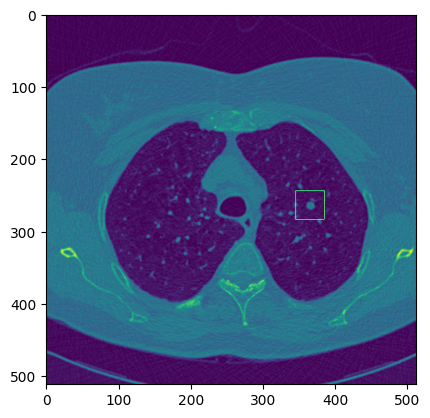

In [121]:
def add_marker(img, loc, size=20):
    mark = np.zeros_like(img)
    new_img = np.copy(img)
    x,y = int(loc[0]),int(loc[1])
    value = img.max() if new_img[x,y]<(img.max()-img.min())/2 else img.min()
    new_img[x-size:x+size,y-size]=value
    new_img[x-size:x+size,y+size]=value
    new_img[x-size,y-size:y+size]=value
    new_img[x+size,y-size:y+size]=value
    return new_img

i=5
print(D[i])
fn = f"{datadir}/subset0/{D[i][1][0]}.mhd"
image,origin,space = read_image(fn)
displacement = np.array(annotations[D[i][0]][1:4]).astype(float)-origin
x,y,z = (displacement/space).astype(int)
loc = np.array([z,y,x])
plt.imshow(add_marker(image[int(loc[0])],loc[1:])),loc

In [107]:
image = sitk.ReadImage(fn, imageIO="MetaImageIO")
image.GetOrigin()

(-145.300003, -174.399994, -347.25)